In [1]:
#install editable version of this repository
# !python -m pip install -e .

In [1]:
import os 
import sys
from importlib import reload

#imports 
import torch
from torch.cuda import memory_allocated, empty_cache
from datasets import load_dataset
from torch.utils.data import DataLoader

# Import local functions ==================================
import activation_extractor
# from activation_extractor import *
# reload(activation_extractor)

/orfeo/cephfs/scratch/area/evillegas/glm/dgxtorch/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
# from activation_extractor.extractors import intermediateExtractorBase 
# reload(intermediateExtractorBase)
# from activation_extractor.inferencers import inferencerBase
# reload(inferencerBase)
# from activation_extractor.model_functions import load_models, tokenize_funs, inference_funs, default_hooked_layers
# reload(load_models)
# reload(tokenize_funs)
# reload(inference_funs)
# reload(default_hooked_layers)

# from activation_extractor.model_functions import embedding_to_numpy
# reload(embedding_to_numpy)
# from activation_extractor.model_functions.embedding_to_numpy import *
reload(activation_extractor)

<module 'activation_extractor' from '/orfeo/cephfs/scratch/area/evillegas/glm/activation-extractor/src/activation_extractor/__init__.py'>

# Proteins/DNA

In [4]:
model_name = "Rostlab/prot_electra_generator_bfd"
inferencer = activation_extractor.Inferencer(model_name, device='cuda', half=False)

/orfeo/cephfs/scratch/area/evillegas/glm/dgxtorch/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


/orfeo/cephfs/scratch/area/evillegas/.cache/huggingface/hub/electra/Rostlab/prot_electra_generator_bfd/vocab.t…

In [5]:
l1, l2, l3 = [], [], []
for i in range(0,32):
    l1.append(inferencer.model.blocks[i].mlp.l1.weight.norm().detach().cpu().to(torch.float32).numpy())
    l2.append(inferencer.model.blocks[i].mlp.l2.weight.norm().detach().cpu().to(torch.float32).numpy())
    l3.append(inferencer.model.blocks[i].mlp.l3.weight.norm().detach().cpu().to(torch.float32).numpy())
    
import matplotlib.pyplot as plt
plt.plot(l1)
plt.plot(l2)
plt.plot(l3)

AttributeError: 'ElectraModel' object has no attribute 'blocks'

In [6]:
# sequences = ["AAAAA", "PPPPPP"]
sequences = ["AAAA"]

In [7]:
#intermediate activation extractor
layers_to_hook = activation_extractor.get_layers_to_hook(inferencer.model,inferencer.model_type)
extractor = activation_extractor.IntermediateExtractor(inferencer.model, layers_to_hook)
extractor.register_hooks()

#inference
processed = inferencer.process(sequences) #tokenize
outputs = inferencer.inference(processed)

#extractor outputs
#extractor.save_outputs('results/embeddings/test')
extractor.clear_all_hooks()

../aten/src/ATen/native/cuda/Indexing.cu:1239: indexSelectSmallIndex: block: [4,0,0], thread: [64,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1239: indexSelectSmallIndex: block: [4,0,0], thread: [65,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1239: indexSelectSmallIndex: block: [4,0,0], thread: [66,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1239: indexSelectSmallIndex: block: [4,0,0], thread: [67,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1239: indexSelectSmallIndex: block: [4,0,0], thread: [68,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1239: indexSelectSmallIndex: block: [4,0,0], thread: [69,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1239: indexSelectSmallIndex: block: [4,0,0], thread: 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
extractor.get_outputs()

In [ ]:
dir = 

# Images 

In [2]:
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

In [4]:
model_name = "timm/vgg16.tv_in1k"
inferencer = activation_extractor.Inferencer(model_name, device='cuda', half=False)

In [5]:
#intermediate activation extractor
layers_to_hook = activation_extractor.get_layers_to_hook(inferencer.model,inferencer.model_type)
extractor = activation_extractor.IntermediateExtractor(inferencer.model, layers_to_hook)
extractor.register_hooks()

#inference
processed = inferencer.process(sequences) #tokenize
outputs = inferencer.inference(processed)

#extractor outputs
#extractor.save_outputs('results/embeddings/test')
extractor.clear_all_hooks()

In [6]:
extractor.get_outputs()

# Text

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import requests
from datasets import load_dataset

In [12]:
ds = load_dataset("ChristophSchuhmann/MS_COCO_2017_URL_TEXT")
text = ds['train']['TEXT'][0]

In [13]:
model_name = "state-spaces/mamba-130m-hf"
inferencer = activation_extractor.Inferencer(model_name, device='cpu', half=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
#intermediate activation extractor
layers_to_hook = activation_extractor.get_layers_to_hook(inferencer.model,inferencer.model_type, modality="sequence")
extractor = activation_extractor.IntermediateExtractor(inferencer.model, layers_to_hook)
extractor.register_hooks()

#inference
processed = inferencer.process(text) #tokenize
outputs = inferencer.inference(processed)

#extractor outputs
#extractor.save_outputs('results/embeddings/test')
extractor.clear_all_hooks()

In [15]:
extractor.get_outputs()

{'backbone.embeddings': tensor([[[ 0.0659, -0.1319,  0.1260,  ...,  0.1190,  0.2410,  0.1532],
          [-0.1701, -0.2475, -0.3468,  ...,  0.4964, -0.2578, -0.2807],
          [-0.1317,  0.2477,  0.1609,  ...,  0.0787, -0.2592,  0.2567],
          ...,
          [-0.1407,  0.3401, -0.3539,  ..., -0.3392, -0.1711, -0.0115],
          [-0.1381,  0.3450,  0.0270,  ...,  0.0933, -0.0996,  0.1867],
          [-0.2955, -0.1018, -0.1997,  ...,  0.0877, -0.0483, -0.0055]]],
        grad_fn=<EmbeddingBackward0>),
 'backbone.layers.0': tensor([[[ 0.0235, -0.0895,  0.1775,  ...,  0.1790,  0.0985,  0.0943],
          [-0.0523, -0.2899, -0.1830,  ...,  0.5059, -0.4524, -0.2202],
          [-0.2401,  0.0946,  0.1220,  ...,  0.0012, -0.2569,  0.0489],
          ...,
          [-0.1446,  0.0361, -0.2066,  ...,  0.8979, -0.3936,  0.1996],
          [-0.0040,  0.0433,  0.1802,  ...,  0.0505, -0.0845,  0.0088],
          [-0.1376, -0.2697, -0.0201,  ..., -0.0991, -0.0847, -0.0928]]],
        grad_fn=<Ad

# Multimodal

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import requests
from datasets import load_dataset

In [46]:
ds = load_dataset("ChristophSchuhmann/MS_COCO_2017_URL_TEXT")

A man with a red helmet on a small moped on a dirt road. 


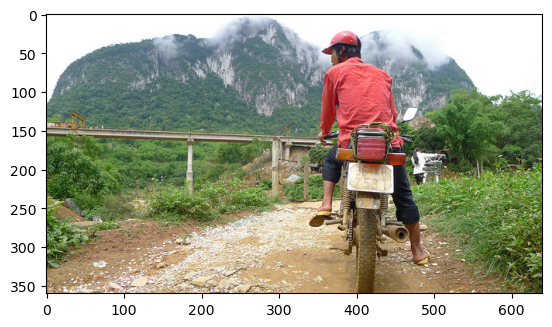

In [45]:
idx = 0

# Open the image file
#online
url = ds['train']['URL'][idx]
# image = Image.open(requests.get(url, stream=True).raw)
# image = np.array(image)

#locally
local_path =  "../data/train2017/train2017/"
image_path = ds['train']['URL'][idx].split("/")[-1]
image_path = os.path.join(local_path,image_path)
img = Image.open(image_path)
img_array = np.array(img)

plt.imshow(img_array)

#text
text = ds['train']['TEXT'][idx]
print(text)

#inputs
input_data = {"text":text,
             "image":img_array
             }


In [37]:
model_name = "openai/clip-vit-base-patch32"
inferencer = activation_extractor.Inferencer(model_name, device='cpu', half=False)

In [38]:
#intermediate activation extractor
layers_to_hook = activation_extractor.get_layers_to_hook(inferencer.model,inferencer.model_type, modality="image-text")
extractor = activation_extractor.IntermediateExtractor(inferencer.model, layers_to_hook)
extractor.register_hooks()

#inference
processed = inferencer.process(input_data) #tokenize
outputs = inferencer.inference(processed)

#extractor outputs
#extractor.save_outputs('results/embeddings/test')
extractor.clear_all_hooks()

In [39]:
extractor.get_outputs()

{'vision_model.embeddings': tensor([[[ 0.0026,  0.0012, -0.0073,  ..., -0.0050,  0.0185, -0.0064],
          [-0.1897,  0.0745,  0.1134,  ..., -0.2790, -0.2884,  0.5225],
          [-0.4061,  0.0035, -0.0268,  ..., -0.0580,  0.1670, -0.1253],
          ...,
          [ 0.1496,  0.0083,  0.0765,  ...,  0.0945, -0.1583,  0.3765],
          [-0.0976,  0.4559,  0.4278,  ..., -0.0683, -0.3129,  0.5966],
          [ 0.2109,  0.2590,  0.4953,  ..., -0.0529,  0.3254, -0.9066]]],
        grad_fn=<AddBackward0>),
 'vision_model.encoder.layers.0': (tensor([[[-0.0026, -0.0186,  0.0012,  ...,  0.0028,  0.0291, -0.0194],
           [-0.0431, -0.0365,  0.0051,  ..., -0.2097, -0.0045,  0.1833],
           [-0.0880,  0.0204,  0.0335,  ...,  0.0744,  0.1332, -0.0348],
           ...,
           [ 0.0330, -0.1296, -0.1038,  ..., -0.0886, -0.1306,  0.1611],
           [ 0.0205,  0.1677,  0.3168,  ..., -0.2339, -0.0280,  0.2429],
           [ 0.1099,  0.1172,  0.2596,  ..., -0.0883,  0.1863, -0.3905]]],
  

# Inference Over a Dataset

## Bio

In [3]:
import numpy as np
from activation_extractor.scripts.inference import main_inference, load_the_data

In [11]:
model_name="Rostlab/ProstT5"
output_folder="test"
emb_format="mean"
save_method="numpy"
max_batches=1

data_args = {
        "data_type":"protein",
        "batch_size":8,
        "data_source":"huggingface",
        "dataset_name":"proteinea/remote_homology",
        "dataset_partition":"train",
        "target_col":"primary",
        # "data_source":"local",
        # "target_col":"protein_seq",
        # "input_path":"/orfeo/LTS/LADE/LT_storage/bio_data/NCBI/NCBI_GP_from_geneid_Plt1000_Glt6000.csv",
        "max_length":1000,
    }


In [12]:
data_loader = load_the_data(**data_args)
batch = next(iter(data_loader))
batch

['VEWTQQERSIIAGIFANLNYEDIGPKALARCLIVYPWTQRYFGAYGDLSTPDAIKGNAKIAAHGVKVLHGLDRAVKNMDNINEAYSELSVLHSDKLHVDPDNFRILGDCLTVVIAANLGDAFTVETQCAFQKFLAVVVFALGRKYH',
 'PIVDTGSVAPLSAAEKTKIRSAWAPVYSTYETSGVDILVKFFTSTPAAQEFFPKFKGLTTADELKKSADVRWHAERIINAVDDAVASMDDTEKMSMKLRNLSGKHAKSFQVDPEYFKVLAAVIADTVAAGDAGFEKLMSMICILLRSAY',
 'LSAAQKDNVKSSWAKASAAWGTAGPEFFMALFDAHDDVFAKFSGLFSGAAKGTVKNTPEMAAQAQSFKGLVSNWVDNLDNAGALEGQCKTFAANHKARGISAGQLEAAFKVLAGFMKSYGGDEGAWTAVAGALMGMIRPDM',
 'GATQSFQSVGDLTPAEKDLIRSTWDQLMTHRTGFVADVFIRIFHNDPTAQRKFPQMAGLSPAELRTSRQMHAHAIRVSALMTTYIDEMDTEVLPELLATLTRTHDKNHVGKKNYDLFGKVLMEAIKAELGVGFTKQVHDAWAKTFAIVQGVLITKHAS',
 'VKLSEDQEHYIKGVWKDVDHKQITAKALERVFVVYPWTTRLFSKLQGLFSANDIGVQQHADKVQRALGEAIDDLKKVEINFQNLSGKHQEIGVDTQNFKLLGQTFMVELALHYKKTFRPKEHAAAYKFFRLVAEALSSNYH',
 'GLSAAQRQVVASTWKDIAGADNGAGVGKECLSKFISAHPEMAAVFGFSGASDPGVAELGAKVLAQIGVAVSHLGDEGKMVAEMKAVGVRHKGYGNKHIKAEYFEPLGASLLSAMEHRIGGKMNAAAKDAWAAAYGDISGALISGLQS',
 'NAADRVMQSYGRCCASTGFFDDFYRHFLASSPQIRAKFATTDMTAQKHLLRAGIMNLVMYARGMSDSKLRALGASHSRAALDIRPE

In [10]:
main_inference(model_name, output_folder, emb_format, save_method, max_batches, data_args)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Output folder is: test/Rostlab/ProstT5/mean


✔️ Rostlab/ProstT5


## For Images

In [2]:
import numpy as np
from PIL import Image

from activation_extractor.scripts.inference import main_inference, load_the_data

from datasets import load_dataset

In [15]:
model_name="microsoft/swin-tiny-patch4-window7-224"
# model_name="google/vit-base-patch16-224-in21k"
output_folder="test"
emb_format="mean"
save_method="numpy"
max_batches=1

data_args = {
        "data_type":"mscoco",
        # "modality":"image-text",
        "modality":"image",
        "batch_size":1,
        "data_source":"huggingface",
        "dataset_name":"ChristophSchuhmann/MS_COCO_2017_URL_TEXT",
        "dataset_partition":"train",
        # "data_source":"local",
        # "input_path":"test.csv",
        "image_source":"local",
        "image_dir":"../data/train2017",
    }

save_args = {
        "save_method":"numpy",
        "emb_format":"mean",
        "sequence_axis": 1,
}

In [4]:
data_loader = load_the_data(**data_args)
input_data = next(iter(data_loader))

In [ ]:
main_inference(model_name, output_folder, save_args, max_batches, data_args)

In [ ]:
     """
--> 137     return F.to_tensor(pic)

File /orfeo/cephfs/scratch/area/evillegas/glm/dgxtorch/lib/python3.10/site-packages/torchvision/transforms/functional.py:140, in to_tensor(pic)
    138     _log_api_usage_once(to_tensor)
    139 if not (F_pil._is_pil_image(pic) or _is_numpy(pic)):
--> 140     raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
    142 if _is_numpy(pic) and not _is_numpy_image(pic):
    143     raise ValueError(f"pic should be 2/3 dimensional. Got {pic.ndim} dimensions.")

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [18]:
def collate_pil(batch):
    """
    Convert PIL images to numpy arrays.
    """
    batch = [np.array(img) for img in batch]

In [34]:
ds = [ np.array(dataset["train"]["img"][i]) for i in range(10) ]

In [36]:
ds[0].shape

(32, 32, 3)

In [60]:
from torchvision.datasets import CIFAR100
import torchvision.transforms as transforms

In [64]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))  # Normalize the images
])

train_dataset = CIFAR100(
    root='./data',  # Directory to store the dataset
    train=True,  # Download the training dataset
    download=True,  # Download if not already downloaded
    transform=transform  # Apply transformations
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,  # Number of samples per batch
    shuffle=True,  # Shuffle the dataset
    num_workers=2,  # Number of subprocesses to use for data loadingt
)

Files already downloaded and verified


In [45]:
data_loader = DataLoader(train_dataset, batch_size=2, 
                             shuffle=False, collate_fn=None)

In [23]:
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np

dataset = load_dataset("uoft-cs/cifar100")
data_loader = DataLoader(dataset["train"], batch_size=2, 
                             shuffle=False, collate_fn=collate_pil)